# Numerical Optimization

This notebook uses the [Optim.jl](https://github.com/JuliaNLSolvers/Optim.jl) package which has general purpose routines for optimization. (As alternatives, consider the [NLopt.jl](https://github.com/JuliaOpt/NLopt.jl) and [JuMP.jl](https://github.com/JuliaOpt/JuMP.jl))

For linear-quadratic problems (mean-variance, least squares, etc), it is probably more efficient use specialized routines. This is discussed in another notebook.

## Load Packages and Extra Functions

In [1]:
using Printf, Optim

include("jlFiles/printmat.jl")

printyellow (generic function with 1 method)

In [2]:
using Plots

gr(size=(480,320))
default(fmt = :png)

# Optimization with One Choice Variable

Running 
```
Sol = optimize(x->fn1(x,0.5),a,b)
```
finds the `x` value (in the interval `[a,b]`) that *minimizes* `fn1(x,0.5)`. The `x->fn1(x,0.5)` syntax makes this a function of `x` only.

The output (`Sol`) contains a lot of information.

In [3]:
function fn1(x,c)                    #notice: the function has two arguments
  value = 2*(x - 1.1)^2 - c
  return value
end

fn1 (generic function with 1 method)

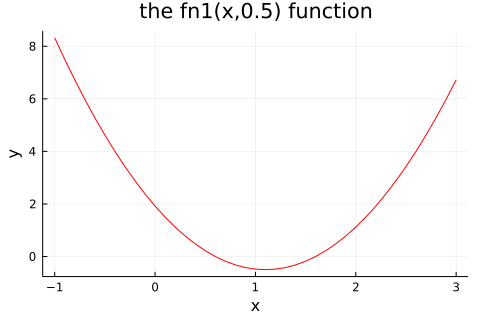

In [4]:
x = -1:0.1:3

p1 = plot( x,fn1.(x,0.5),
           linecolor = :red,
           linewidth = 1,
           legend = nothing,
           title = "the fn1(x,0.5) function",
           xlabel = "x",
           ylabel = "y" )
display(p1)

In [5]:
Sol = optimize(x->fn1(x,0.5),-2.0,3.0)
println(Sol)

printlnPs("\nThe minimum is at: ", Optim.minimizer(Sol))     #the optimal x value
println("Compare with the plot above\n")

Results of Optimization Algorithm
 * Algorithm: Brent's Method
 * Search Interval: [-2.000000, 3.000000]
 * Minimizer: 1.100000e+00
 * Minimum: -5.000000e-01
 * Iterations: 5
 * Convergence: max(|x - x_upper|, |x - x_lower|) <= 2*(1.5e-08*|x|+2.2e-16): true
 * Objective Function Calls: 6

The minimum is at:      1.100
Compare with the plot above



## One Choice Variable: Supplying a Starting Guess Instead (extra)

If you prefer to give a starting guess `c` instead of an interval, then supply it as as a vector `[c]`.

In [6]:
Solb = optimize(x->fn1(x[],0.5),[0.1])

printlnPs("The minimum is at: ", Optim.minimizer(Solb))

The minimum is at:      1.100


# Several Choice Variables: Unconstrained Optimization

In the example below, we choose $(x,y)$ so as to minimize the fairly simple objective function

$
(x-2)^2 + (4y+3)^2,  
$

without any constraints. The solution should be $(x,y)=(2,-3/4)$.

In [7]:
function fn2(θ)
    (x,y) = (θ[1],θ[2])          #unpack the choice variables and get nicer names
     L    = (x-2)^2 + (4*y+3)^2
    return L
end

fn2 (generic function with 1 method)

In [8]:
nx = 2*41
ny = 2*61
x = range(1,5,length=nx)
y = range(-1,0,length=ny)

loss2d = fill(NaN,(nx,ny))      #matrix with loss fn values
for i = 1:nx, j = 1:ny
    loss2d[i,j] = fn2([x[i];y[j]])
end

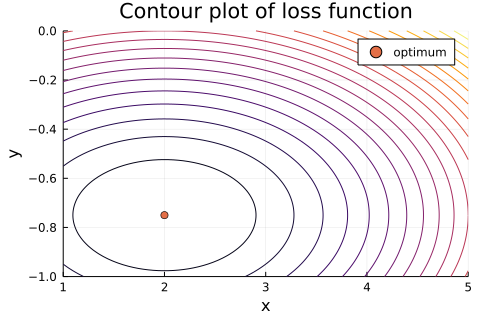

In [9]:
p1 = contour( x,y,loss2d',       #notice: loss2d'
              xlims = (1,5),
              ylims = (-1,0),
              legend = false,
              levels = 21,
              title = "Contour plot of loss function",
              xlabel = "x",
              ylabel = "y" )
scatter!([2],[-0.75],label="optimum",legend=true)
display(p1)

In [10]:
θ₀ = [4.0,-0.5]               #starting guess

Sol = optimize(fn2,θ₀)        #use θ->lossfn(θ,other arguments) if there are
                              #additional (non-choice) function arguments
printlnPs("minimum at (x,y)= ",Optim.minimizer(Sol))

minimum at (x,y)=      2.000    -0.750


# Several Choice Variables: Bounds on the Solutions

The next few cells discuss how to impose bounds on the solution.

In the example below, we impose $2.75 \leq x$ (a lower bound) and $y \leq -0.3$ (an upper bound). We will see that only one of these restrictions binds.

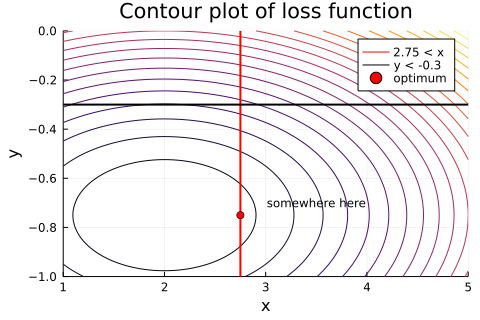

In [11]:
p1 = contour( x,y,loss2d',
              xlims = (1,5),
              ylims = (-1,0),
              legend = false,
              levels = 21,
              title = "Contour plot of loss function",
              xlabel = "x",
              ylabel = "y",
              annotation = (3.5,-0.7,text("somewhere here",8)) )
plot!([2.75,2.75],[-1,0.5],color=:red,linewidth=2,label="2.75 < x",legend = true)
plot!([1,5],[-0.3,-0.3],color=:black,linewidth=2,label="y < -0.3")
scatter!([2.75],[-0.75],color=:red,label="optimum")
display(p1)

In [12]:
lower_θ = [2.75, -Inf]
upper_θ = [Inf, -0.3]

Sol = optimize(fn2,lower_θ,upper_θ,θ₀)
printlnPs("The optimum is at (x,y) = ",Optim.minimizer(Sol))

The optimum is at (x,y) =      2.750    -0.750


# Several Choice Variables: Equality Restrictions

We now impose the constraint that $x+2y-3=0.$ The `Optim.jl` package can handle this, but the syntax is a bit more involved than in the earlier examples. The remarks below discuss this. (Clearly, we could handle this single linear equality constraint by rewriting the objecive function instead, so consider this as just a simple illustration.)

### Remarks on the Code

1. `TwiceDifferentiable(fn2,θ₀)` and `TwiceDifferentiableConstraints(EqConstrfun!,lower_θ,upper_θ,lower_c,upper_c)` tell the `optimize()` function that the objective function and constraint are differentiable (twice).

2. The function for the constraint (`EqConstrfun!(c,θ)`) takes two inputs: `c` will be filled (by `optimize()`) with the calculations in the function and `θ` is the vector of choice variables.

3. `lower_θ` and `upper_θ` are (vectors of) bounds on the choice variables. With no bounds, use `[-Inf,-Inf]` and `[Inf,Inf]`.

4. `lower_c` and `upper_c` are (vectors of) bounds on the output from the constraint function. With a single equality constraint, use `[0.0]` for both.

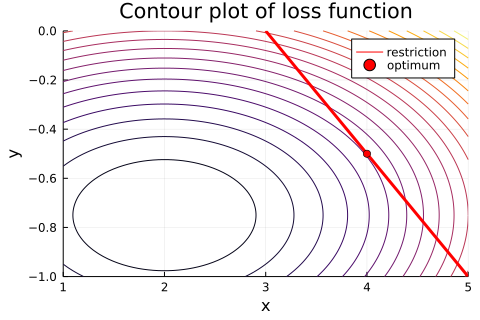

In [13]:
p1 = contour(x,y,loss2d',
             xlims = (1,5),
             ylims = (-1,0),
             legend = false,
             levels = 21, 
             title = "Contour plot of loss function",
             xlabel = "x",
             ylabel = "y" )
plot!(3 .- 2*y,y,linecolor=:red,linewidth=3,label="restriction",legend=true)
scatter!([4],[-0.5],markercolor=:red,label="optimum")
display(p1)

In [14]:
function EqConstrfun!(c,θ)       #a function for a constraint
    (x,y) = (θ[1],θ[2])          #c is an array where results are written to
    c[1]  = x + 2*y - 3
    return c
end

lower_θ = [-Inf,-Inf]                 #effectively no bounds on the parameters
upper_θ = [Inf,  Inf]
lower_c = [0.0]                       #c from EqConstrfun! should be lower_c <= c <= upper_c
upper_c = [0.0]

df  = TwiceDifferentiable(fn2,θ₀)       #informing about the differentiability of the problem
dfc = TwiceDifferentiableConstraints(EqConstrfun!,lower_θ,upper_θ,lower_c,upper_c)
Sol = optimize(df,dfc,θ₀,IPNewton())
println("Constrained, x+2y-3=0")
println(Optim.minimizer(Sol))

Constrained, x+2y-3=0
[4.000000000001833, -0.5000000000009167]


# Optimization with Inequality Constraints

We now impose the non-linear constraint that $y \le -(x-4)^2$, that is, $y + (x-4)^2 \le 0$.

This is very similar to the linear constraint above, except that we need a new constraint function and that `lower_c = [-Inf]` and `upper_c = [0.0]`.

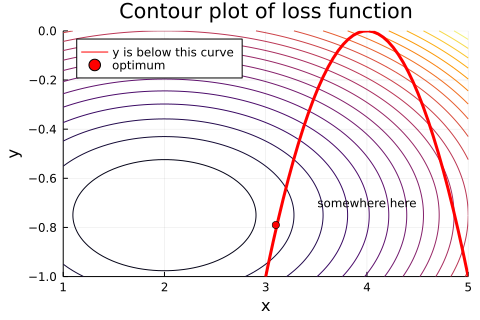

In [15]:
yRestriction = -(x.-4).^2               #y should be less than this

p1 = contour( x,y,loss2d',
              legend = false,
              levels = 21,
              title = "Contour plot of loss function",
              xlabel = "x",
              ylabel = "y",
              xlims = (1,5),
              ylims = (-1,0),
              annotation = (4.0,-0.7,text("somewhere here",8)) )
plot!(x,yRestriction,linecolor=:red,linewidth=3,label="y is below this curve",legend=:topleft)
scatter!([3.1],[-0.79],markercolor=:red,label="optimum")
display(p1)

In [16]:
function IneqConstrfun!(c,θ)       #another restriction
    (x,y) = (θ[1],θ[2])
    c[1]  = y + (x-4)^2
  return c
end

lower_θ = [-Inf,-Inf]                   #effectively no bounds on the parameters
upper_θ = [Inf,Inf]
lower_c = [-Inf]                        # -Inf <= c <= 0.0
upper_c = [0.0]

df  = TwiceDifferentiable(fn2,θ₀)       
dfc = TwiceDifferentiableConstraints(IneqConstrfun!,lower_θ,upper_θ,lower_c,upper_c)
Sol = optimize(df,dfc,θ₀,IPNewton())
println("Constrained, y + (x-4)^2 <= 0")
println(Optim.minimizer(Sol))

Constrained, y + (x-4)^2 <= 0
[3.1116826368546797, -0.7891077376654559]


# Several Choice Variables:  Supplying the Gradient (extra)

Supplying a function for calculating the derivatives improves speed and accuracy. See below for an example.

In [17]:
function g2!(G,θ)                        #derivatives of fn2 wrt. θ[1] and θ[2]
    (x,y) = (θ[1],θ[2])
    G[:] = [2*(x-2), 2*4*(4*y+3)]        #fills an existing vector
    return G
end

Sol3 = optimize(fn2,g2!,[1.0,-0.5])
println(Sol3)
println(Optim.minimizer(Sol3))

 * Status: success

 * Candidate solution
    Final objective value:     9.860761e-30

 * Found with
    Algorithm:     L-BFGS

 * Convergence measures
    |x - x'|               = 9.34e-01 ≰ 0.0e+00
    |x - x'|/|x'|          = 4.67e-01 ≰ 0.0e+00
    |f(x) - f(x')|         = 8.75e-01 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 8.88e+28 ≰ 0.0e+00
    |g(x)|                 = 2.49e-14 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    2
    f(x) calls:    7
    ∇f(x) calls:   7

[2.0000000000000004, -0.7500000000000008]
